## Calc de gradient vector for a cavity. 

# Ahora voy a probar con un desplazamiento negativo y otro positivo, p/ calcular la derivada con estos 2 puntos y así obtener la derivada p/ el punto central (la struct average)

In [2]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Distributions
using MIToS.PDB
set_default_plot_size(28cm, 10cm)

In [3]:
function meta_var(s::AbstractString,v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [4]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [5]:
function read_ptraj_modes(file, modes_elements)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    for i=1:nmodes
        mode[: ,i] = mode[:, i] / norm(mode[:, i])
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 1 method)

In [6]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

# Gradiente en base de modos de PCA

### Preparo variables y leo archivos de pdb y modos.

In [9]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
pdb_name = "mtn"
filename_pdb_file_original = string("/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/cut_avg_", pdb_name, ".pdb")
mtn_pdb = read(filename_pdb_file_original, PDBFile, group="ATOM");
# Obtengo el número de átomos de c/ residuo
for i=1:length(mtn_pdb)
    push!(natom_res, length(mtn_pdb[i]))
end
shift!(natom_res)
# Obtengo el nro de aa's
aa = length(mtn_pdb)
aa3 = aa * 3
modo_sum = Array{Float64}(aa, 3);

# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn_1 = Array{Float64}(aa3-6);
vol_pocket_mtn_2 = Array{Float64}(aa3-6);
vol_pocket_mtn_3 = Array{Float64}(aa3-6);
vol_ndd = Array{Float64, 2}(0, 2);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_mtn, evals_mtn = read_ptraj_modes("/home/german/labo/16/hemo/run/mtn/pca/modes_mtn", aa3);

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/hemo/cavities/newana_mode_gradient/mtn/"
# Archivos de config de ANA
conf_mtn_corto = "/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/mtn_corto.cfg"
conf_mtn_portal = "/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/mtn_portal.cfg"
conf_mtn_largo = "/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/mtn_largo.cfg"
conf_mtn_whole = "/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/mtn_whole.cfg"

"/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/mtn_largo.cfg"

### Desplazo la estructura original a lo largo de cada modo. Los modos son normalizados y luego multiplicados por -2 y 2; y así obtener distintos desplazamientos. Creando así 2 sets, c/u de 339 estructuras desplazadas (1 por c/ modo)

In [8]:
constant = 1
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar 
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [-2 2]
    if magnitude >= 0
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3-6
        for i=1:aa
            modo_sum[i, 1] = modes_mtn[i*3-2, j]
            modo_sum[i, 2] = modes_mtn[i*3-1, j]
            modo_sum[i, 3] = modes_mtn[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q 
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1            
                temp1_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
                continue
            end
            temp2_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factor = magnitude * constant 
# Modifico las coordenadas
        mtn_atom_xyz = coordinatesmatrix(mtn_pdb)
        new_mtn_atom_xyz = mtn_atom_xyz + modo_sum .* factor;
# Obtengo un nuevo frame con las coordenadas modificadas
        new_mtn_pdb = change_coordinates(mtn_pdb, new_mtn_atom_xyz)
# Escribo el nuevo .pdb
        pdb_mtn = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mtn.pdb")
        write(pdb_mtn, new_mtn_pdb, PDBFile)
    end
end

### Ahora calculo los volumenes de los huecos corto, portal, largo y whole p/ los 2 sets de 345 estructuras desplazadas. Y así junto 2 sets (1 por c/ magnitud de desplazamiento) de 4 vectores (1 por c/ hueco) de 345 elementos c/u (1 elemento -> 1 volumen de 1 hueco de 1 estructura desplazada en alguna de sus coordenadas x,y,z)
### Luego le resto los volumenes originales de los huecos corto, portal, largo y whole a c/u de los elementos de los 8 vectores y así obtengo 2 sets de 4 vectores gradiente en base de coordenadas cartesianas.

In [36]:
# Obtengo los vectores de volúmenes p/ los 4 huecos con desplazamientos negativos y positivos
for magnitude in [-2; 2]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    # Preparo variables
    ndd_input_filename = string(files_template, displacement, "/inndd_", pdb_name, "_", displacement)
    ndd_output_filename = string(files_template, displacement, "/outndd_", pdb_name, "_", displacement)
    pdb_filename = string("/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/cut_avg_mtn.pdb")

# CORTO
    
    global vol_ndd = symbol("vol_ndd_corto_", displacement)  
    global gdte_ndd = symbol("gdte_ndd_corto_", displacement)  
    # Calculo el pocket        
    run(`ANA $pdb_filename -c $conf_mtn_corto -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readall(`ANA $pdb_filename -c $conf_mtn_corto`)))

# PORTAL
    
    global vol_ndd = symbol("vol_ndd_portal_", displacement)
    global gdte_ndd = symbol("gdte_ndd_portal_", displacement)  
    # Calculo el pocket        
    run(`ANA $pdb_filename -c $conf_mtn_portal -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readall(`ANA $pdb_filename -c $conf_mtn_portal`)))
    
# LARGO
    
    global vol_ndd = symbol("vol_ndd_largo_", displacement)
    global gdte_ndd = symbol("gdte_ndd_largo_", displacement)  
    # Calculo el pocket        
    run(`ANA $pdb_filename -c $conf_mtn_largo -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readall(`ANA $pdb_filename -c $conf_mtn_largo`)))
    
# WHOLE
    
    global vol_ndd = symbol("vol_ndd_whole_", displacement)
    global gdte_ndd = symbol("gdte_ndd_whole_", displacement)  
    # Calculo el pocket        
    run(`ANA $pdb_filename -c $conf_mtn_whole -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readall(`ANA $pdb_filename -c $conf_mtn_whole`)))
    
end

222.977
646.906
1168.26
3179.11
222.977
646.906
1168.26
3179.11


In [44]:
# Ahora obtengo el gradiente entre los desplazamientos negativo y positivo.
gdte_ndd_corto_dd2 = vol_ndd_corto_d2 - vol_ndd_corto_d_2
gdte_ndd_portal_dd2 = vol_ndd_portal_d2 - vol_ndd_portal_d_2
gdte_ndd_largo_dd2 = vol_ndd_largo_d2 - vol_ndd_largo_d_2
gdte_ndd_whole_dd2 = vol_ndd_whole_d2 - vol_ndd_whole_d_2;

In [46]:
# Los vectores tienen el (delta)volumen. Puedo elegir normalizarlos o dividirlos por el desplazamiento
# o lo q sea. Los normalizo
# CORTO 
gdte_ndd_corto_d2 = gdte_ndd_corto_d2 / norm(gdte_ndd_corto_d2) 
gdte_ndd_corto_d_2 = gdte_ndd_corto_d_2 / norm(gdte_ndd_corto_d_2)
gdte_ndd_corto_dd2 = gdte_ndd_corto_dd2 / norm(gdte_ndd_corto_dd2)

# PORTAL
gdte_ndd_portal_d2 = gdte_ndd_portal_d2 / norm(gdte_ndd_portal_d2)
gdte_ndd_portal_d_2 = gdte_ndd_portal_d_2 / norm(gdte_ndd_portal_d_2)
gdte_ndd_portal_dd2 = gdte_ndd_portal_dd2 / norm(gdte_ndd_portal_dd2)

# LARGO
gdte_ndd_largo_d2 = gdte_ndd_largo_d2 / norm(gdte_ndd_largo_d2)
gdte_ndd_largo_d_2 = gdte_ndd_largo_d_2 / norm(gdte_ndd_largo_d_2)
gdte_ndd_largo_dd2 = gdte_ndd_largo_dd2 / norm(gdte_ndd_largo_dd2)

# WHOLE
gdte_ndd_whole_d2 = gdte_ndd_whole_d2 / norm(gdte_ndd_whole_d2)
gdte_ndd_whole_d_2 = gdte_ndd_whole_d_2 / norm(gdte_ndd_whole_d_2)
gdte_ndd_whole_dd2 = gdte_ndd_whole_dd2 / norm(gdte_ndd_whole_dd2);

## Grafico los vectores. El eje 'x' es el nro de elemento y el 'y' el valor del elemento.

### Canal corto

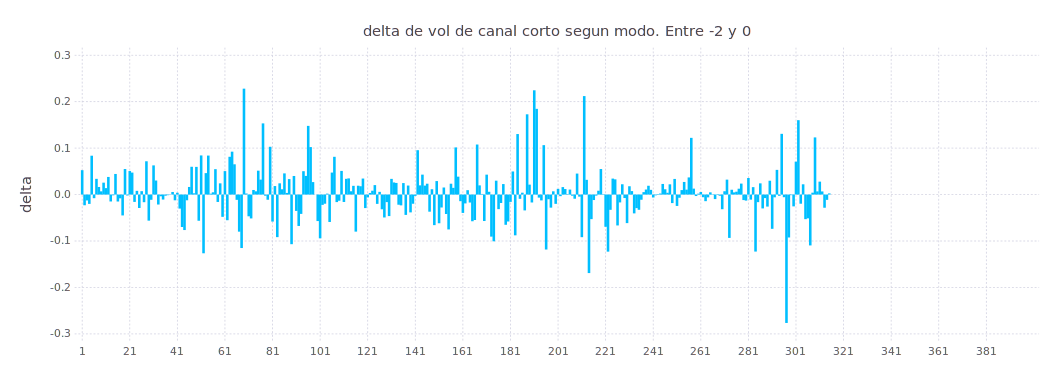

In [47]:
df_gdte_corto = DataFrame(delta = gdte_ndd_corto_d_2)
pdf_gdte_corto = plot(df_gdte_corto,
y="delta",  
Geom.bar(position=:dodge),
Guide.Title("delta de vol de canal corto segun modo. Entre -2 y 0"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

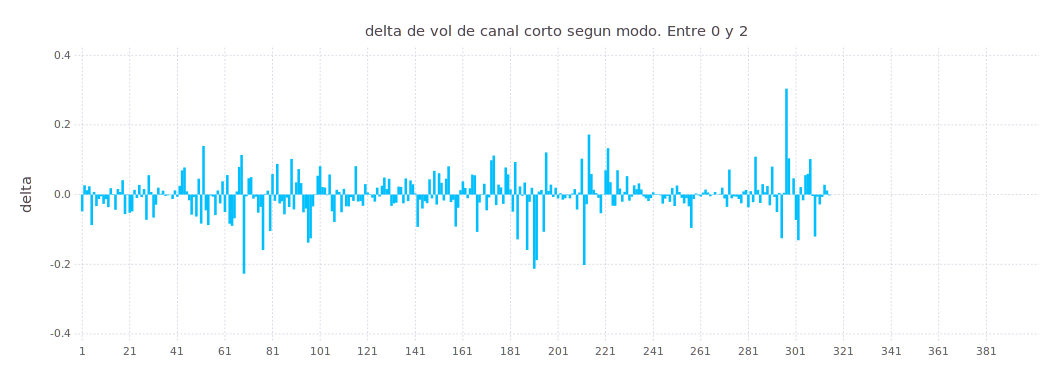

In [48]:
df_gdte_corto = DataFrame(delta = gdte_ndd_corto_d2)
pdf_gdte_corto = plot(df_gdte_corto,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal corto segun modo. Entre 0 y 2"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

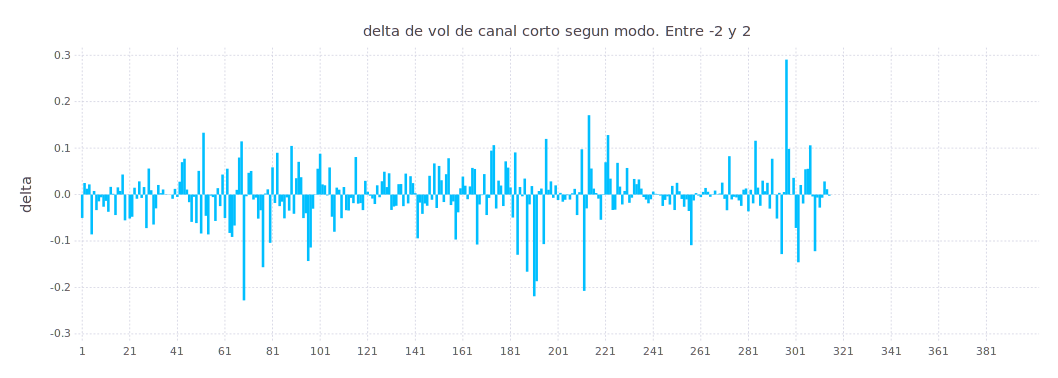

In [49]:
df_gdte_corto = DataFrame(delta = gdte_ndd_corto_dd2)
pdf_gdte_corto = plot(df_gdte_corto,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal corto segun modo. Entre -2 y 2"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

### Comparo los vectores obtenidos entre [-2;0] [0;2] [-2;2]

In [53]:
dot(gdte_ndd_corto_d_2, gdte_ndd_corto_d2) 

-0.9952540956373033

In [52]:
dot(gdte_ndd_corto_dd2, gdte_ndd_corto_d_2)

-0.9988170142801582

In [51]:
dot(gdte_ndd_corto_d2, gdte_ndd_corto_dd2)

0.9988086167196252

### Canal portal

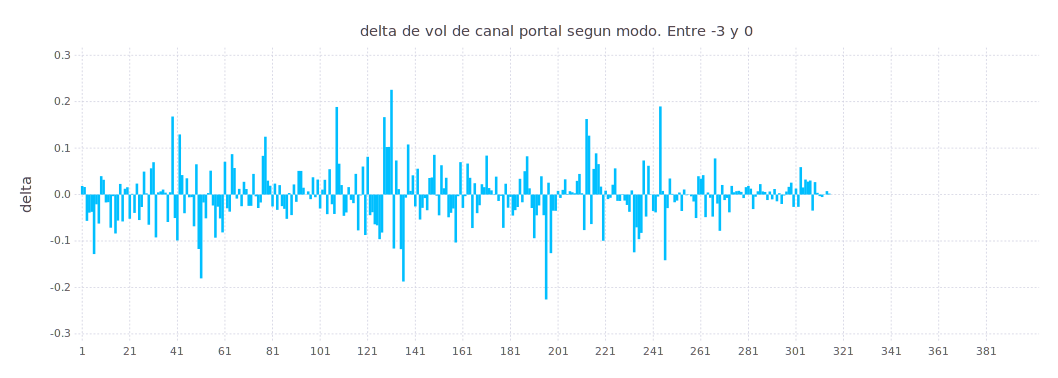

In [55]:
df_gdte_portal = DataFrame(delta = gdte_ndd_portal_d_2)
pdf_gdte_portal = plot(df_gdte_portal,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal portal segun modo. Entre -3 y 0"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

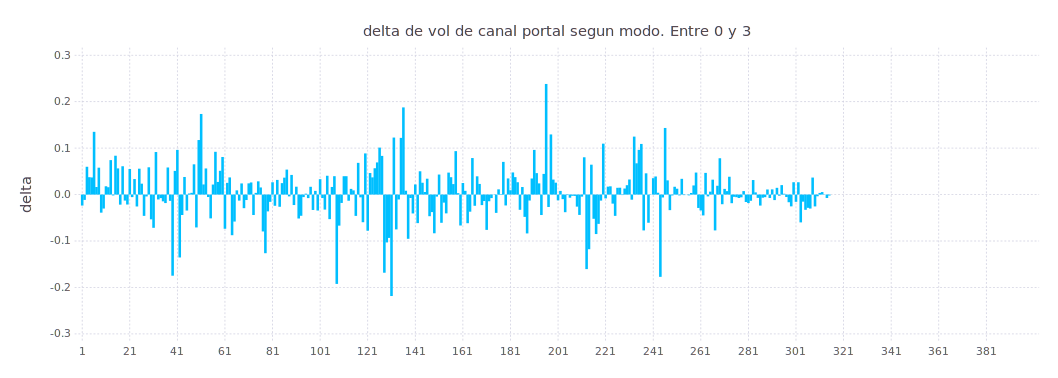

In [56]:
df_gdte_portal = DataFrame(delta = gdte_ndd_portal_d2)
pdf_gdte_portal = plot(df_gdte_portal,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal portal segun modo. Entre 0 y 3"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

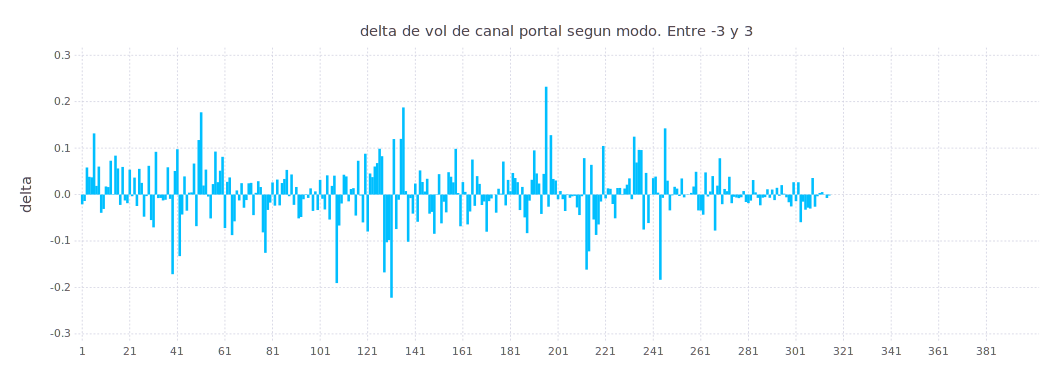

In [57]:
df_gdte_portal = DataFrame(delta = gdte_ndd_portal_dd2)
pdf_gdte_portal = plot(df_gdte_portal,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal portal segun modo. Entre -3 y 3"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

### Comparo los vectores obtenidos entre [-3;0] [0;3] [-3;3]

In [58]:
dot(gdte_ndd_portal_d_2, gdte_ndd_portal_d2)

-0.9973490550685044

In [59]:
dot(gdte_ndd_portal_dd2, gdte_ndd_portal_d_2)

-0.9993371072433681

In [60]:
dot(gdte_ndd_portal_d2, gdte_ndd_portal_dd2)

0.9993369807772274

### Canal largo

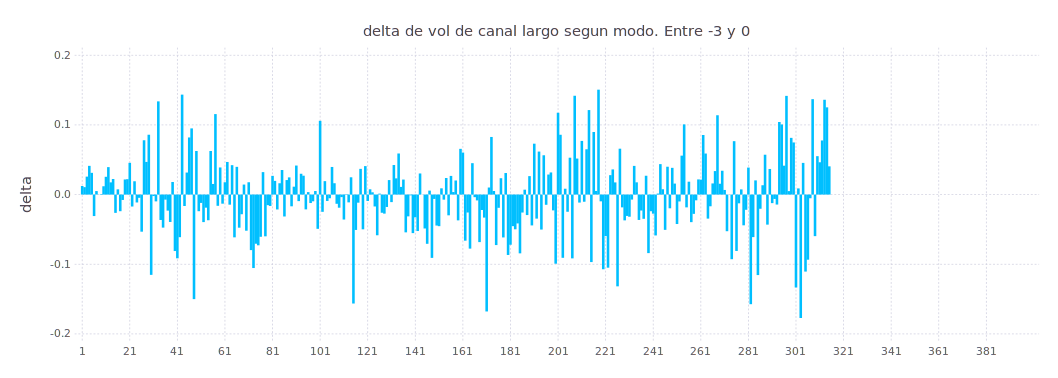

In [61]:
df_gdte_largo = DataFrame(delta = gdte_ndd_largo_d_2)
pdf_gdte_largo = plot(df_gdte_largo,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal largo segun modo. Entre -3 y 0"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

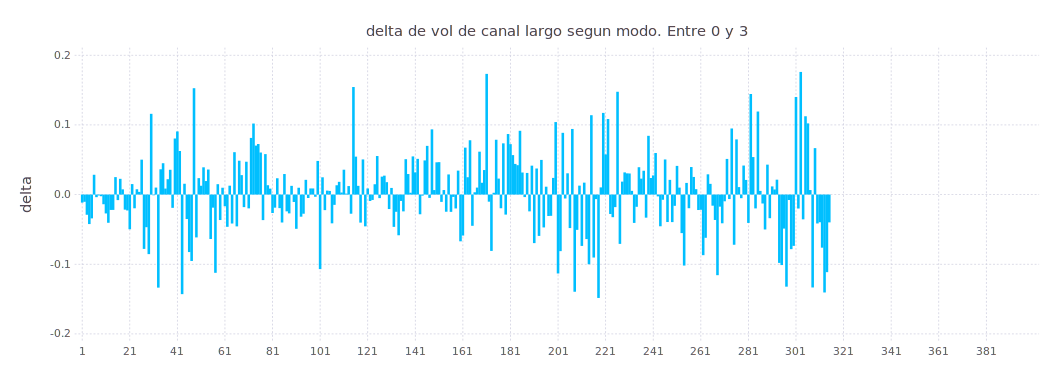

In [62]:
df_gdte_largo = DataFrame(delta = gdte_ndd_largo_d2)
pdf_gdte_largo = plot(df_gdte_largo,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal largo segun modo. Entre 0 y 3"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

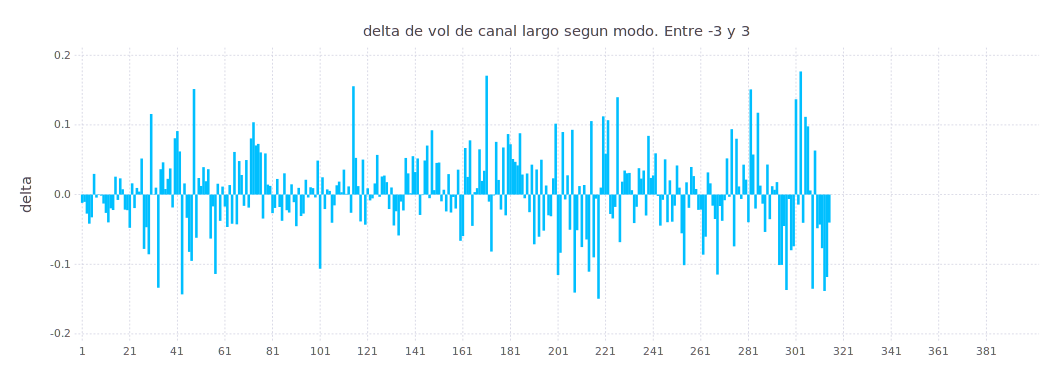

In [63]:
df_gdte_largo = DataFrame(delta = gdte_ndd_largo_dd2)
pdf_gdte_largo = plot(df_gdte_largo,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal largo segun modo. Entre -3 y 3"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

### Comparo los vectores obtenidos entre [-3;0] [0;3] [-3;3]

In [64]:
dot(gdte_ndd_largo_d_2, gdte_ndd_largo_d2)

-0.9975609696078964

In [65]:
dot(gdte_ndd_largo_d_2, gdte_ndd_largo_dd2)

-0.9993911214224135

In [66]:
dot(gdte_ndd_largo_dd2, gdte_ndd_largo_d2)

0.999388990419953

### Canal whole

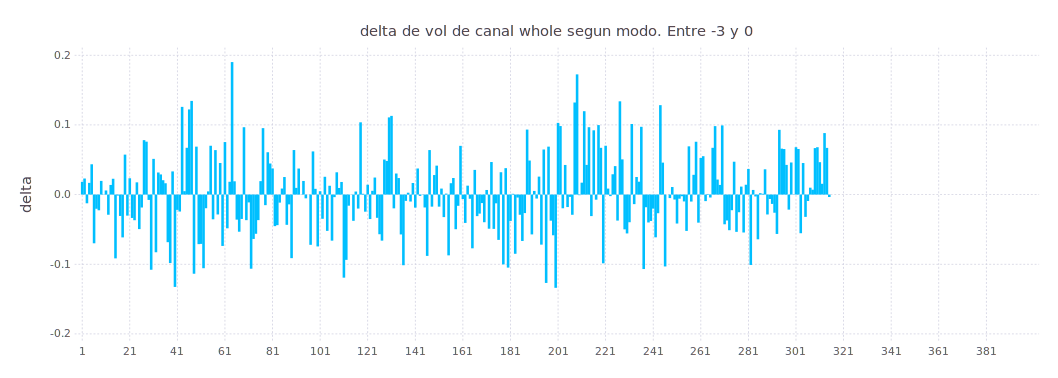

In [67]:
df_gdte_whole = DataFrame(delta = gdte_ndd_whole_d_2)
pdf_gdte_whole = plot(df_gdte_whole,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal whole segun modo. Entre -3 y 0"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

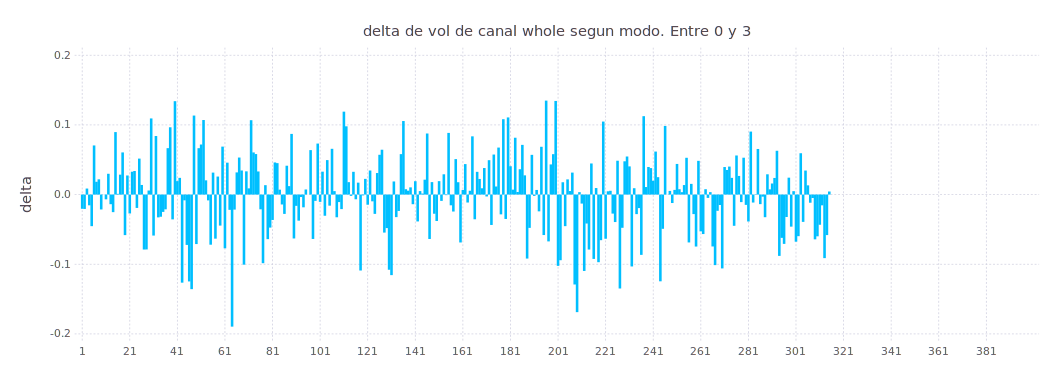

In [68]:
df_gdte_whole = DataFrame(delta = gdte_ndd_whole_d2)
pdf_gdte_whole = plot(df_gdte_whole,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal whole segun modo. Entre 0 y 3"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

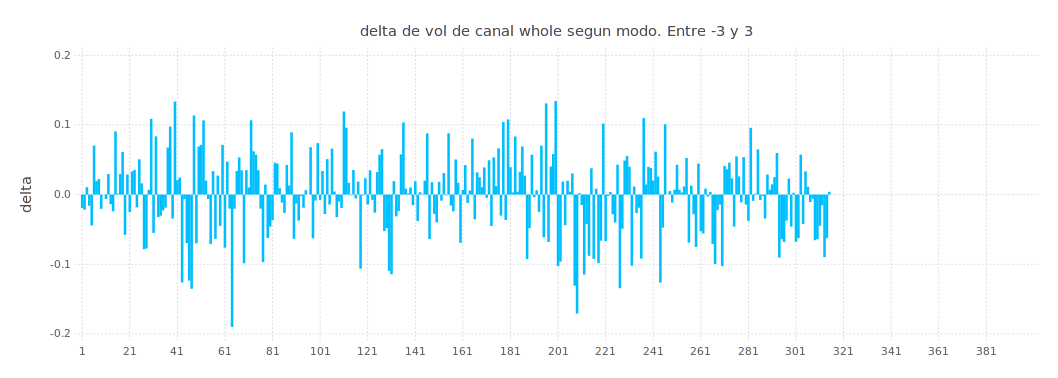

In [69]:
df_gdte_whole = DataFrame(delta = gdte_ndd_whole_dd2)
pdf_gdte_whole = plot(df_gdte_whole,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal whole segun modo. Entre -3 y 3"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

### Comparo los vectores obtenidos entre [-3;0] [0;3] [-3;3]

In [70]:
dot(gdte_ndd_whole_d_2, gdte_ndd_whole_d2)

-0.9977446216762773

In [71]:
dot(gdte_ndd_whole_dd2, gdte_ndd_whole_d_2)

-0.9994394748506725

In [72]:
dot(gdte_ndd_whole_d2, gdte_ndd_whole_dd2)

0.9994325071304738

### Guardo los 4 gráficos en 1 pdf

In [74]:
magnitude = 2
displacement = string("dd", magnitude)
out_filename_pdf_gdte_corto = string("/home/german/labo/16/hemo/rtdos_log/newana_", displacement,"_corto_mtn.pdf")
out_filename_pdf_gdte_portal = string("/home/german/labo/16/hemo/rtdos_log/newana_", displacement,"_portal_mtn.pdf")
out_filename_pdf_gdte_largo = string("/home/german/labo/16/hemo/rtdos_log/newana_", displacement,"_largo_mtn.pdf")
out_filename_pdf_gdte_whole = string("/home/german/labo/16/hemo/rtdos_log/newana_", displacement,"_whole_mtn.pdf")
out_filename_pdf_gdtes = string("/home/german/labo/16/hemo/rtdos_log/newana_", displacement,"_mtn.pdf")
# Guardo los plots
draw(PDF(out_filename_pdf_gdte_corto, 20cm, 10cm), pdf_gdte_corto)
draw(PDF(out_filename_pdf_gdte_portal, 20cm, 10cm), pdf_gdte_portal)
draw(PDF(out_filename_pdf_gdte_largo, 20cm, 10cm), pdf_gdte_largo)
draw(PDF(out_filename_pdf_gdte_whole, 20cm, 10cm), pdf_gdte_whole)
run(`pdftk $out_filename_pdf_gdte_corto $out_filename_pdf_gdte_portal $out_filename_pdf_gdte_largo $out_filename_pdf_gdte_whole output $out_filename_pdf_gdtes`)
run(`rm $out_filename_pdf_gdte_corto`)
run(`rm $out_filename_pdf_gdte_portal`)
run(`rm $out_filename_pdf_gdte_largo`)
run(`rm $out_filename_pdf_gdte_whole`)